# Italian Financial Challenge

**Student Name:** Simone Prezioso, Claudio De Acutis, Alexandre Viallard, Alessandro Vertunni 

**Challenge:** Financial Health Classification

**Date:** 5/02/2026

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** 
We chose the "Financial Health Classification" in order to push ourselves outside our comfort zone just enough to learn as much as much as possible while working on an amazingly interesting project, we didn't want to go for something too easy such as task 1 or something that would've required time that we didnt have such as task 3.

**Objective:** 
Our goal is to build a model capable of confidently classifying companies into 4 distinct categories based on their financial "health":
A: Excellent financial health
B: Good financial health
C: Moderate risk
D: High risk / Distressed

**Success Criteria:** 
We can divide our criteria into 3 categories:
1) Metrics: Weighted F1-score ≥ 0.65 on the held-out test set
2) Errors: No extreme ordinal errors, specifically no A → D or D → A misclassifications in the confusion matrix
3) Interpretability: Clear and class-specific feature importance analysis (e.g. per-class SHAP values or one-vs-rest explanations), with financially coherent drivers for classes A, B, C, and D.

**Approach:** [Briefly outline your planned approach]

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import xgboost as xgb
import lightgbm as lgb
import imblearn as imb
import shap 
import plotly as px

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 67
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Exploration

Load the training data and perform initial exploration.

In [ ]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")

display(train_df.head())


Dataset shape: (11828, 30)

Columns: ['company_id', 'fiscal_year', 'province', 'region', 'ateco_sector', 'legal_form', 'years_in_business', 'total_fixed_assets', 'current_assets', 'total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'operating_income', 'financial_income', 'financial_expenses', 'net_profit_loss', 'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio', 'debt_to_assets', 'profit_margin', 'bankruptcy_next_year', 'financial_health_class', 'revenue_change']

First few rows:


,company_id,fiscal_year,province,region,ateco_sector,legal_form,years_in_business,total_fixed_assets,current_assets,total_assets,shareholders_equity,total_debt,short_term_debt,long_term_debt,production_value,production_costs,operating_income,financial_income,financial_expenses,net_profit_loss,roe,roi,leverage,current_ratio,quick_ratio,debt_to_assets,profit_margin,bankruptcy_next_year,financial_health_class,revenue_change
0,COMP_00000,2018,NaN,Campania,47,SRL,32,2.422343e+08,9.504819e+08,1.192716e+09,3.728702e+08,8.198459e+08,5.601842e+08,2.596617e+08,1.846636e+09,1.611363e+09,2.352729e+08,4886785.12,20068071.29,2.152049e+08,0.5772,0.1973,2.1987,1.6967,1.0180,0.6874,0.1165,0,B,NaN
1,COMP_00000,2019,NaN,Campania,47,SRL,33,3.983639e+07,1.411226e+08,1.809589e+08,5.700701e+07,1.239519e+08,7.135345e+07,5.259848e+07,4.289159e+08,3.896038e+08,3.931218e+07,58246.06,2537224.20,3.677495e+07,0.6451,0.2172,2.1743,1.9778,1.1867,0.6850,0.0857,0,B,-76.77
2,COMP_00000,2020,NaN,Campania,47,SRL,34,6.662250e+08,1.367208e+09,2.033433e+09,3.029046e+08,1.730529e+09,9.904004e+08,7.401282e+08,6.956197e+09,6.988489e+09,-3.229208e+07,5327332.51,55844558.38,-8.813664e+07,-0.2910,-0.0159,5.7131,1.3805,0.8283,0.8510,-0.0127,0,D,1521.81
3,COMP_00000,2021,NaN,Campania,47,SRL,35,4.637187e+07,2.524228e+08,2.987947e+08,3.901098e+07,2.597837e+08,1.527674e+08,1.070163e+08,5.031839e+08,5.047235e+08,-1.539645e+06,116335.80,7828741.61,-9.368387e+06,-0.2401,-0.0052,6.6592,1.6523,0.9914,0.8694,-0.0186,0,D,-92.77
4,COMP_00001,2018,CA,Sardegna,62,SRL,8,8.348035e+07,1.325697e+08,2.160500e+08,6.566937e+07,1.503807e+08,7.582482e+07,7.455584e+07,4.113380e+08,3.912414e+08,2.009667e+07,640538.94,5860639.22,1.423603e+07,0.2168,0.0930,2.2900,1.7484,1.0490,0.6960,0.0346,0,B,NaN


In [ ]:
# Basic information
train_df.info()
cateogrical_cols = train_df.select_dtypes(include=['object', 'category']).columns
train_df['ateco_sector'] = train_df['ateco_sector'].astype('category') # Convert 'ateco_sector' to categorical since numbers represent categories and not continuous values
print(f"\nCategorical columns: {cateogrical_cols.tolist()}")

numerical_cols = train_df.select_dtypes(include=['number']).columns
print(f"\nNumerical columns: {numerical_cols.tolist()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11828 entries, 0 to 11827
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_id              11828 non-null  object 
 1   fiscal_year             11828 non-null  int64  
 2   province                10909 non-null  object 
 3   region                  11828 non-null  object 
 4   ateco_sector            11828 non-null  int64  
 5   legal_form              11828 non-null  object 
 6   years_in_business       11828 non-null  int64  
 7   total_fixed_assets      11828 non-null  float64
 8   current_assets          11828 non-null  float64
 9   total_assets            11828 non-null  float64
 10  shareholders_equity     11828 non-null  float64
 11  total_debt              11828 non-null  float64
 12  short_term_debt         11828 non-null  float64
 13  long_term_debt          11828 non-null  float64
 14  production_value        11828 non-null

In [4]:
# Summary statistics
train_df.describe()

,fiscal_year,years_in_business,total_fixed_assets,current_assets,total_assets,shareholders_equity,total_debt,short_term_debt,long_term_debt,production_value,production_costs,operating_income,financial_income,financial_expenses,net_profit_loss,roe,roi,leverage,current_ratio,quick_ratio,debt_to_assets,profit_margin,bankruptcy_next_year,revenue_change
count,11828.000000,11828.000000,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,1.182800e+04,11783.000000,11828.000000,11783.000000,11828.000000,11828.000000,11828.000000,11828.000000,11828.000000,8829.000000
mean,2019.495350,35.179405,1.029206e+09,1.438435e+09,2.467641e+09,9.163141e+08,1.551327e+09,8.534656e+08,6.978617e+08,3.969063e+09,3.680129e+09,2.889337e+08,6.418314e+06,5.464980e+07,2.342839e+08,0.254267,0.123253,2.135329,1.869953,1.121972,0.633231,0.058008,0.007102,453.434570
std,1.116482,19.908095,6.120958e+09,6.873106e+09,1.248305e+10,5.023564e+09,7.724478e+09,4.360360e+09,3.493369e+09,1.896096e+10,1.757911e+10,1.574126e+09,3.930832e+07,2.850800e+08,1.348222e+09,0.577374,0.091036,2.159040,0.614015,0.368409,0.114868,0.039245,0.083976,4601.920625
min,2018.000000,0.000000,1.267167e+06,1.278800e+06,2.545968e+06,-3.330561e+09,1.839791e+06,8.985461e+05,9.412449e+05,2.329670e+06,1.580518e+06,-2.688184e+09,6.241000e+01,5.926949e+04,-4.062689e+09,-39.177100,-0.475300,0.818200,0.551000,0.330600,0.450000,-0.149700,0.000000,-99.940000
25%,2018.000000,18.000000,7.319803e+07,1.244471e+08,2.087793e+08,7.070428e+07,1.294646e+08,6.925617e+07,5.666362e+07,2.984883e+08,2.731290e+08,1.698626e+07,3.569547e+05,4.355200e+06,1.049173e+07,0.110350,0.061900,1.165650,1.430800,0.858500,0.538500,0.030500,0.000000,-68.590000
50%,2019.000000,35.000000,1.905995e+08,3.125597e+08,5.212379e+08,1.815958e+08,3.264152e+08,1.744802e+08,1.462585e+08,8.040019e+08,7.459428e+08,5.128590e+07,1.068330e+06,1.110262e+07,3.798727e+07,0.221600,0.105000,1.680300,1.811750,1.087050,0.627500,0.060300,0.000000,3.040000
75%,2020.000000,52.000000,5.398741e+08,8.387197e+08,1.394478e+09,5.022747e+08,8.795087e+08,4.777298e+08,3.960070e+08,2.241163e+09,2.075266e+09,1.538062e+08,3.178533e+06,3.005698e+07,1.226862e+08,0.390750,0.170900,2.484850,2.238925,1.343325,0.713800,0.090000,0.000000,238.850000
max,2021.000000,71.000000,2.548712e+11,2.512549e+11,5.061262e+11,1.956145e+11,3.105116e+11,1.699685e+11,1.405431e+11,6.044366e+11,5.736470e+11,5.621927e+10,1.640114e+09,9.311030e+09,5.011818e+10,1.771600,0.490600,101.153800,4.539300,2.723600,1.192300,0.120000,1.000000,302126.480000


Missing Values:
                Missing Count  Percentage
revenue_change           2999   25.355090
province                  919    7.769699
roe                        45    0.380453
leverage                   45    0.380453


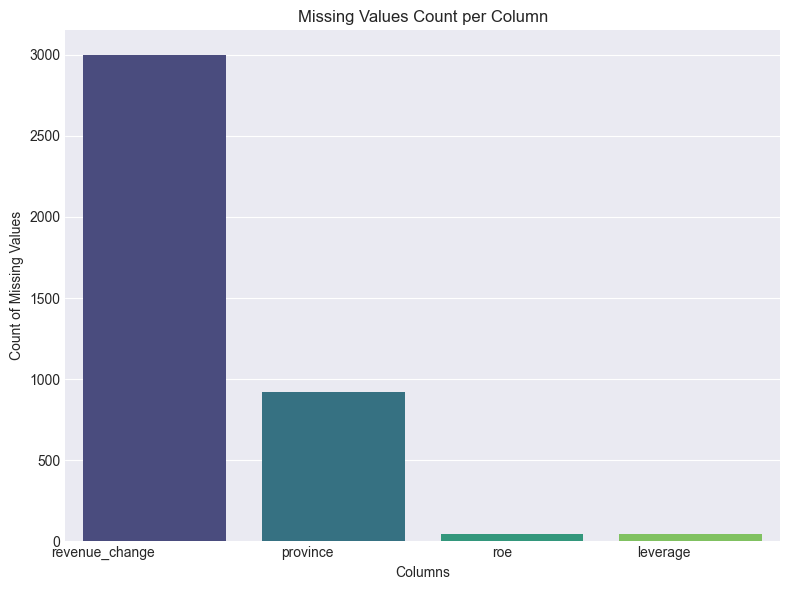

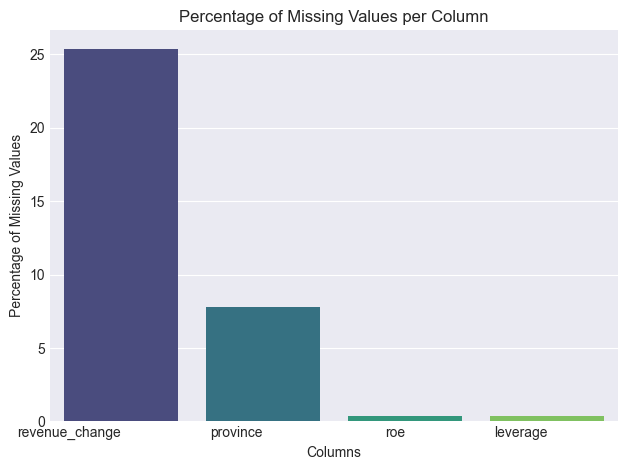

In [ ]:
# Check for missing values
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values:")
print(missing_df)
missing_counts = train_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

plt.figure(figsize=(8,6))                  
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
plt.xticks( ha='right')
plt.title('Missing Values Count per Column')
plt.ylabel('Count of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()

plt.show()  


sns.barplot(x=missing_df.index, y=missing_df['Percentage'], palette='viridis')
plt.xticks(ha='right')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Columns')
plt.tight_layout()

plt.show()



Financial Health Distribution:
financial_health_class
A    1003
B    7017
C    2750
D    1058
Name: count, dtype: int64


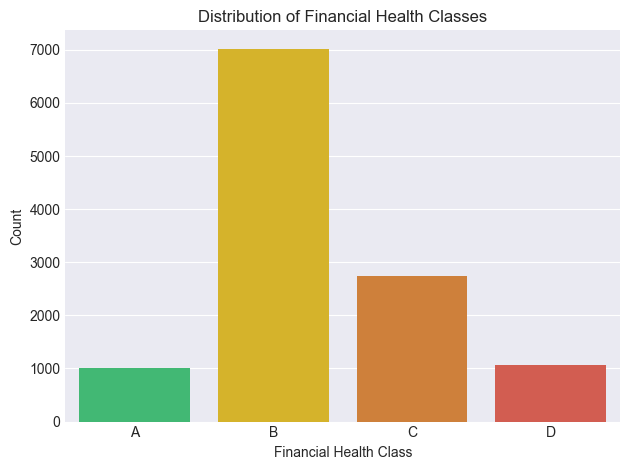


Percentages:
financial_health_class
A    0.0848
B    0.5933
C    0.2325
D    0.0894
Name: proportion, dtype: float64


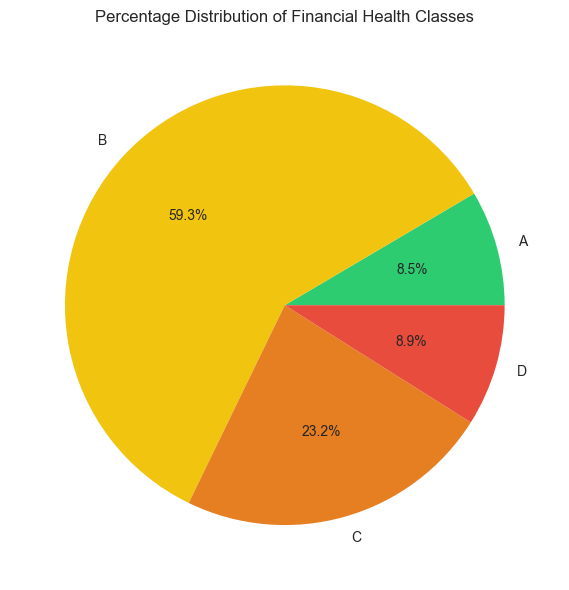

In [ ]:
#Financial Health Classification
class_counts = train_df['financial_health_class'].value_counts().sort_index()
print("\nFinancial Health Distribution:")
print(class_counts)

sns.countplot(x='financial_health_class',  data=train_df, order=class_counts.index, palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
plt.title('Distribution of Financial Health Classes')
plt.xlabel('Financial Health Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()  
print("\nPercentages:")
perchentages=train_df['financial_health_class'].value_counts(normalize=True).sort_index().round(4)
print(perchentages)
plt.figure(figsize=(8, 6))

plt.pie(class_counts, 
    labels=class_counts.index, 
    autopct='%1.1f%%', 
    colors=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'])
plt.title('Percentage Distribution of Financial Health Classes')
plt.tight_layout()
plt.show()  

imbalance_ratio = class_counts.max() / class_counts.min()
if imbalance_ratio > 3 or perchentages.min() < 0.1:
    print(f"\nWarning: The dataset is imbalanced with a ratio of {imbalance_ratio:.2f}.") 

### Exploratory Data Analysis (EDA)

Create visualizations to understand the data better.

The main categories of financial ratios are:

Liquidity ratios: Short-term payment ability
Leverage ratios: Debt and capital structure
Efficiency ratios: Asset use and productivity
Profitability ratios: Profit relative to sales, assets, or equity
Market value ratios: Valuation and investor returns

Columns: ['company_id', 'fiscal_year', 'province', 'region', 'ateco_sector', 'legal_form', 'years_in_business', 'total_fixed_assets', 'current_assets', 'total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'operating_income', 'financial_income', 'financial_expenses', 'net_profit_loss', 'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio', 'debt_to_assets', 'profit_margin', 'bankruptcy_next_year', 'financial_health_class', 'revenue_change']

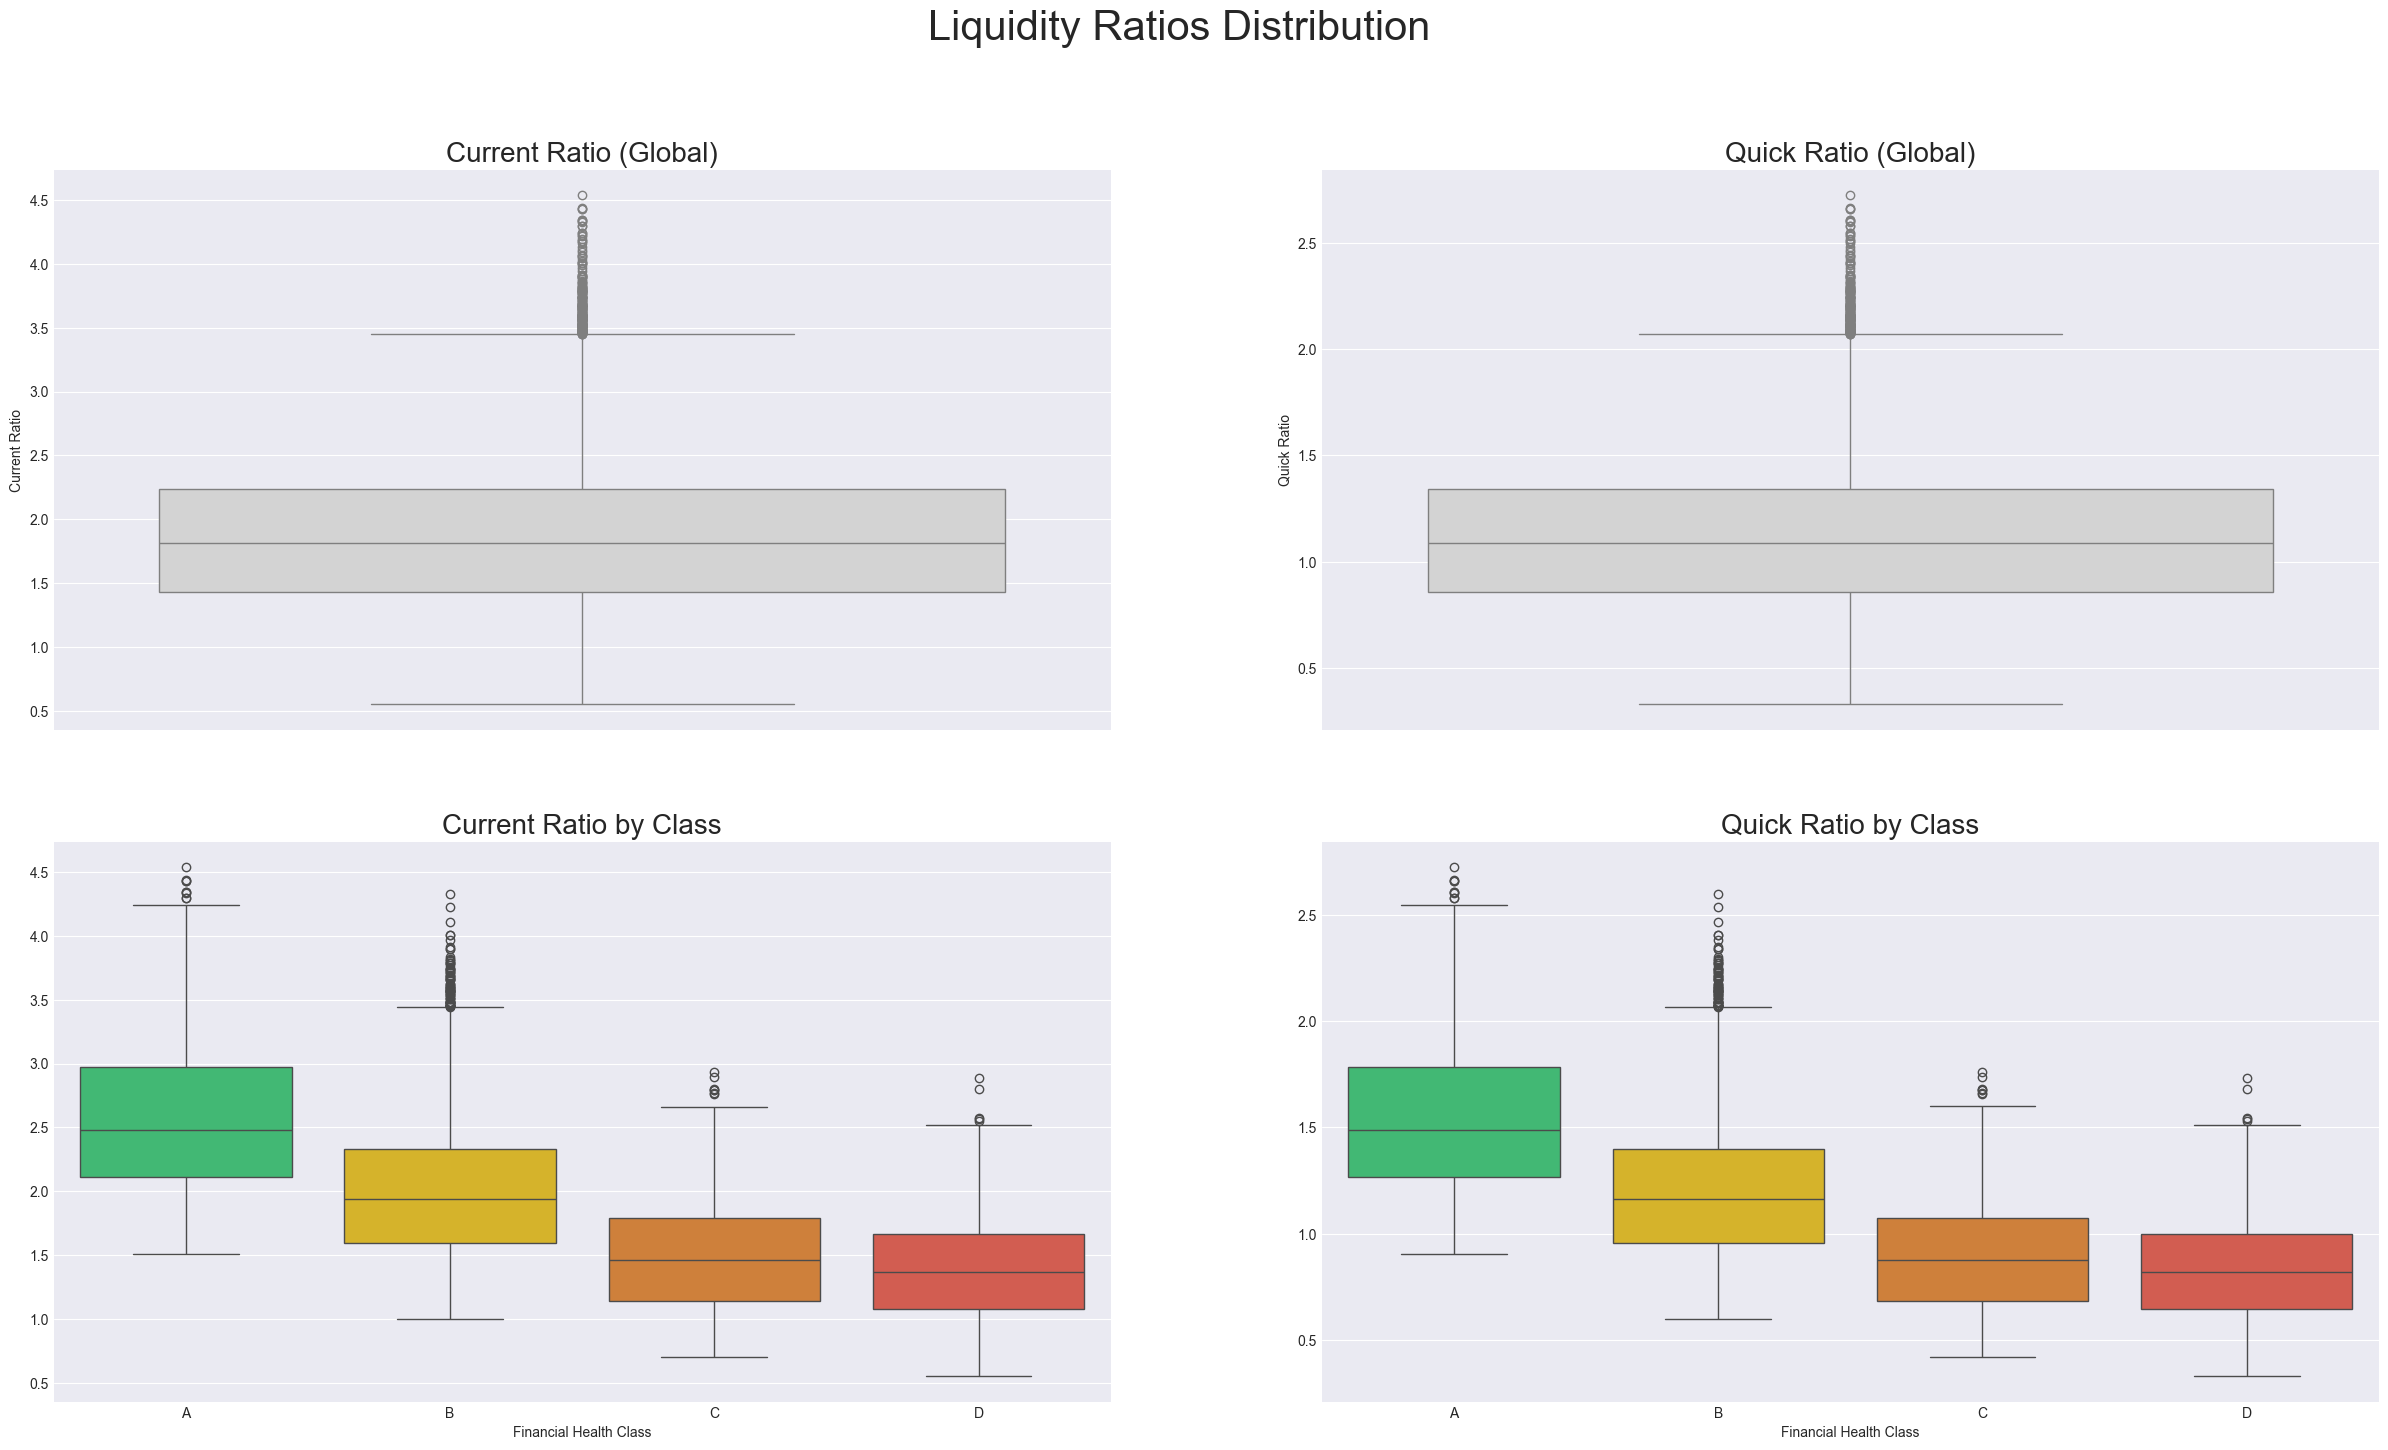

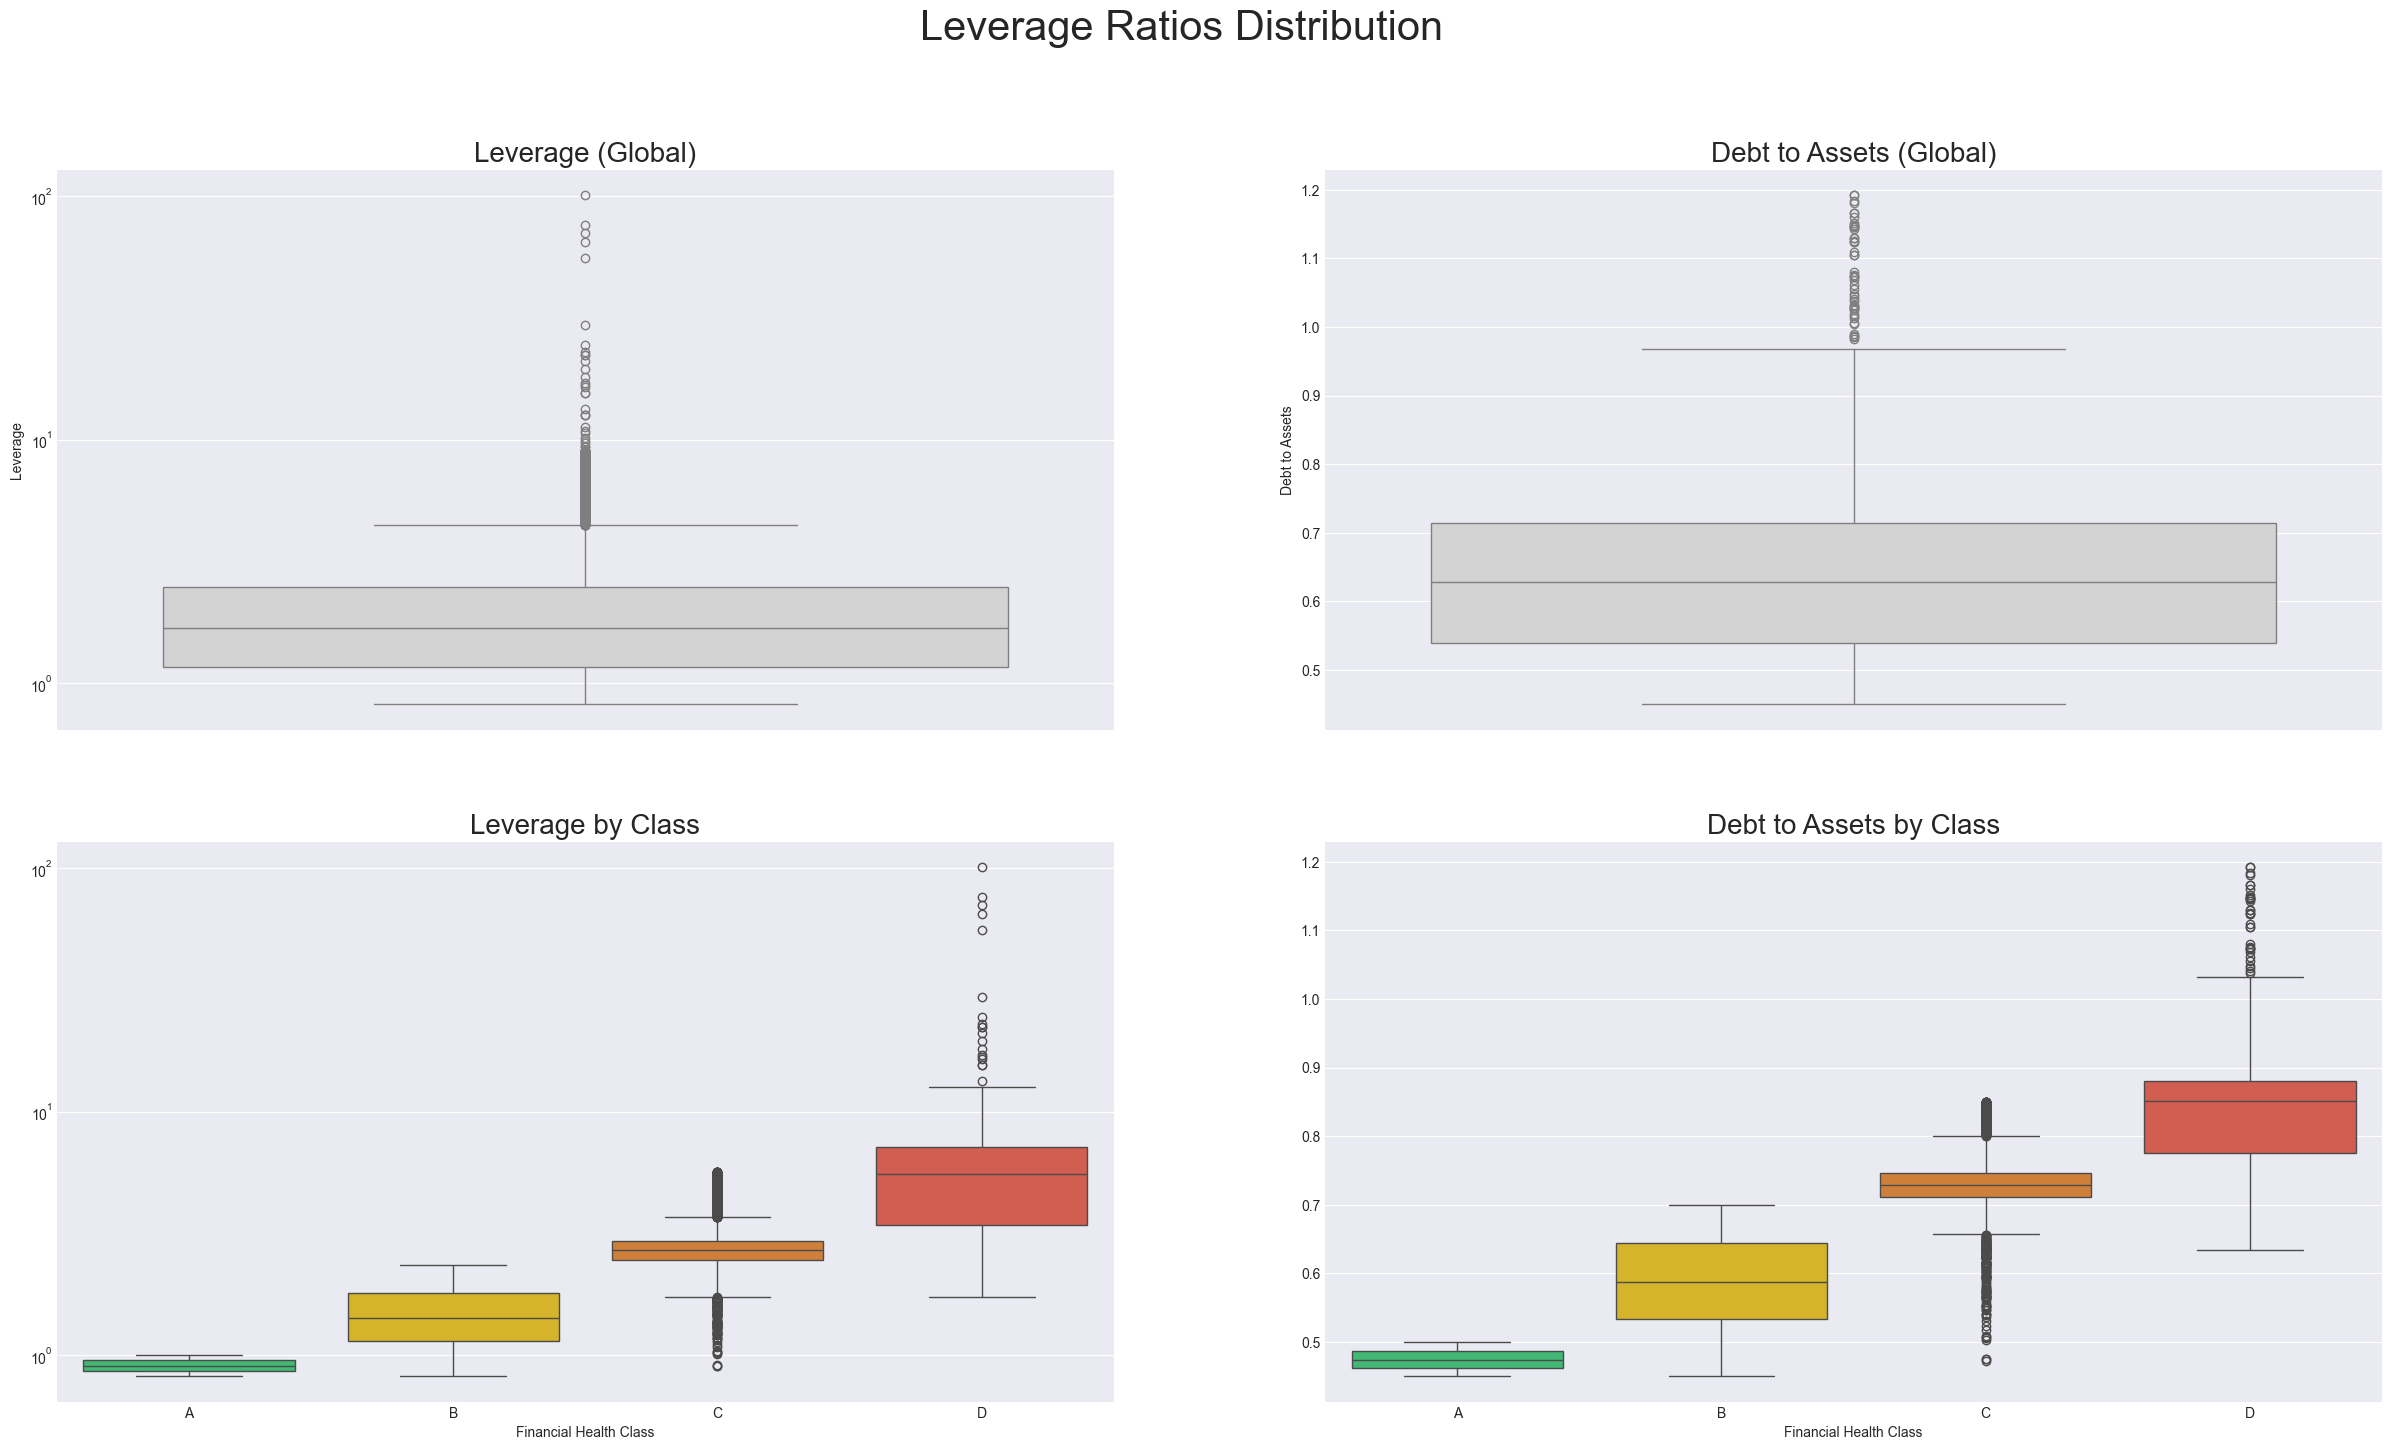

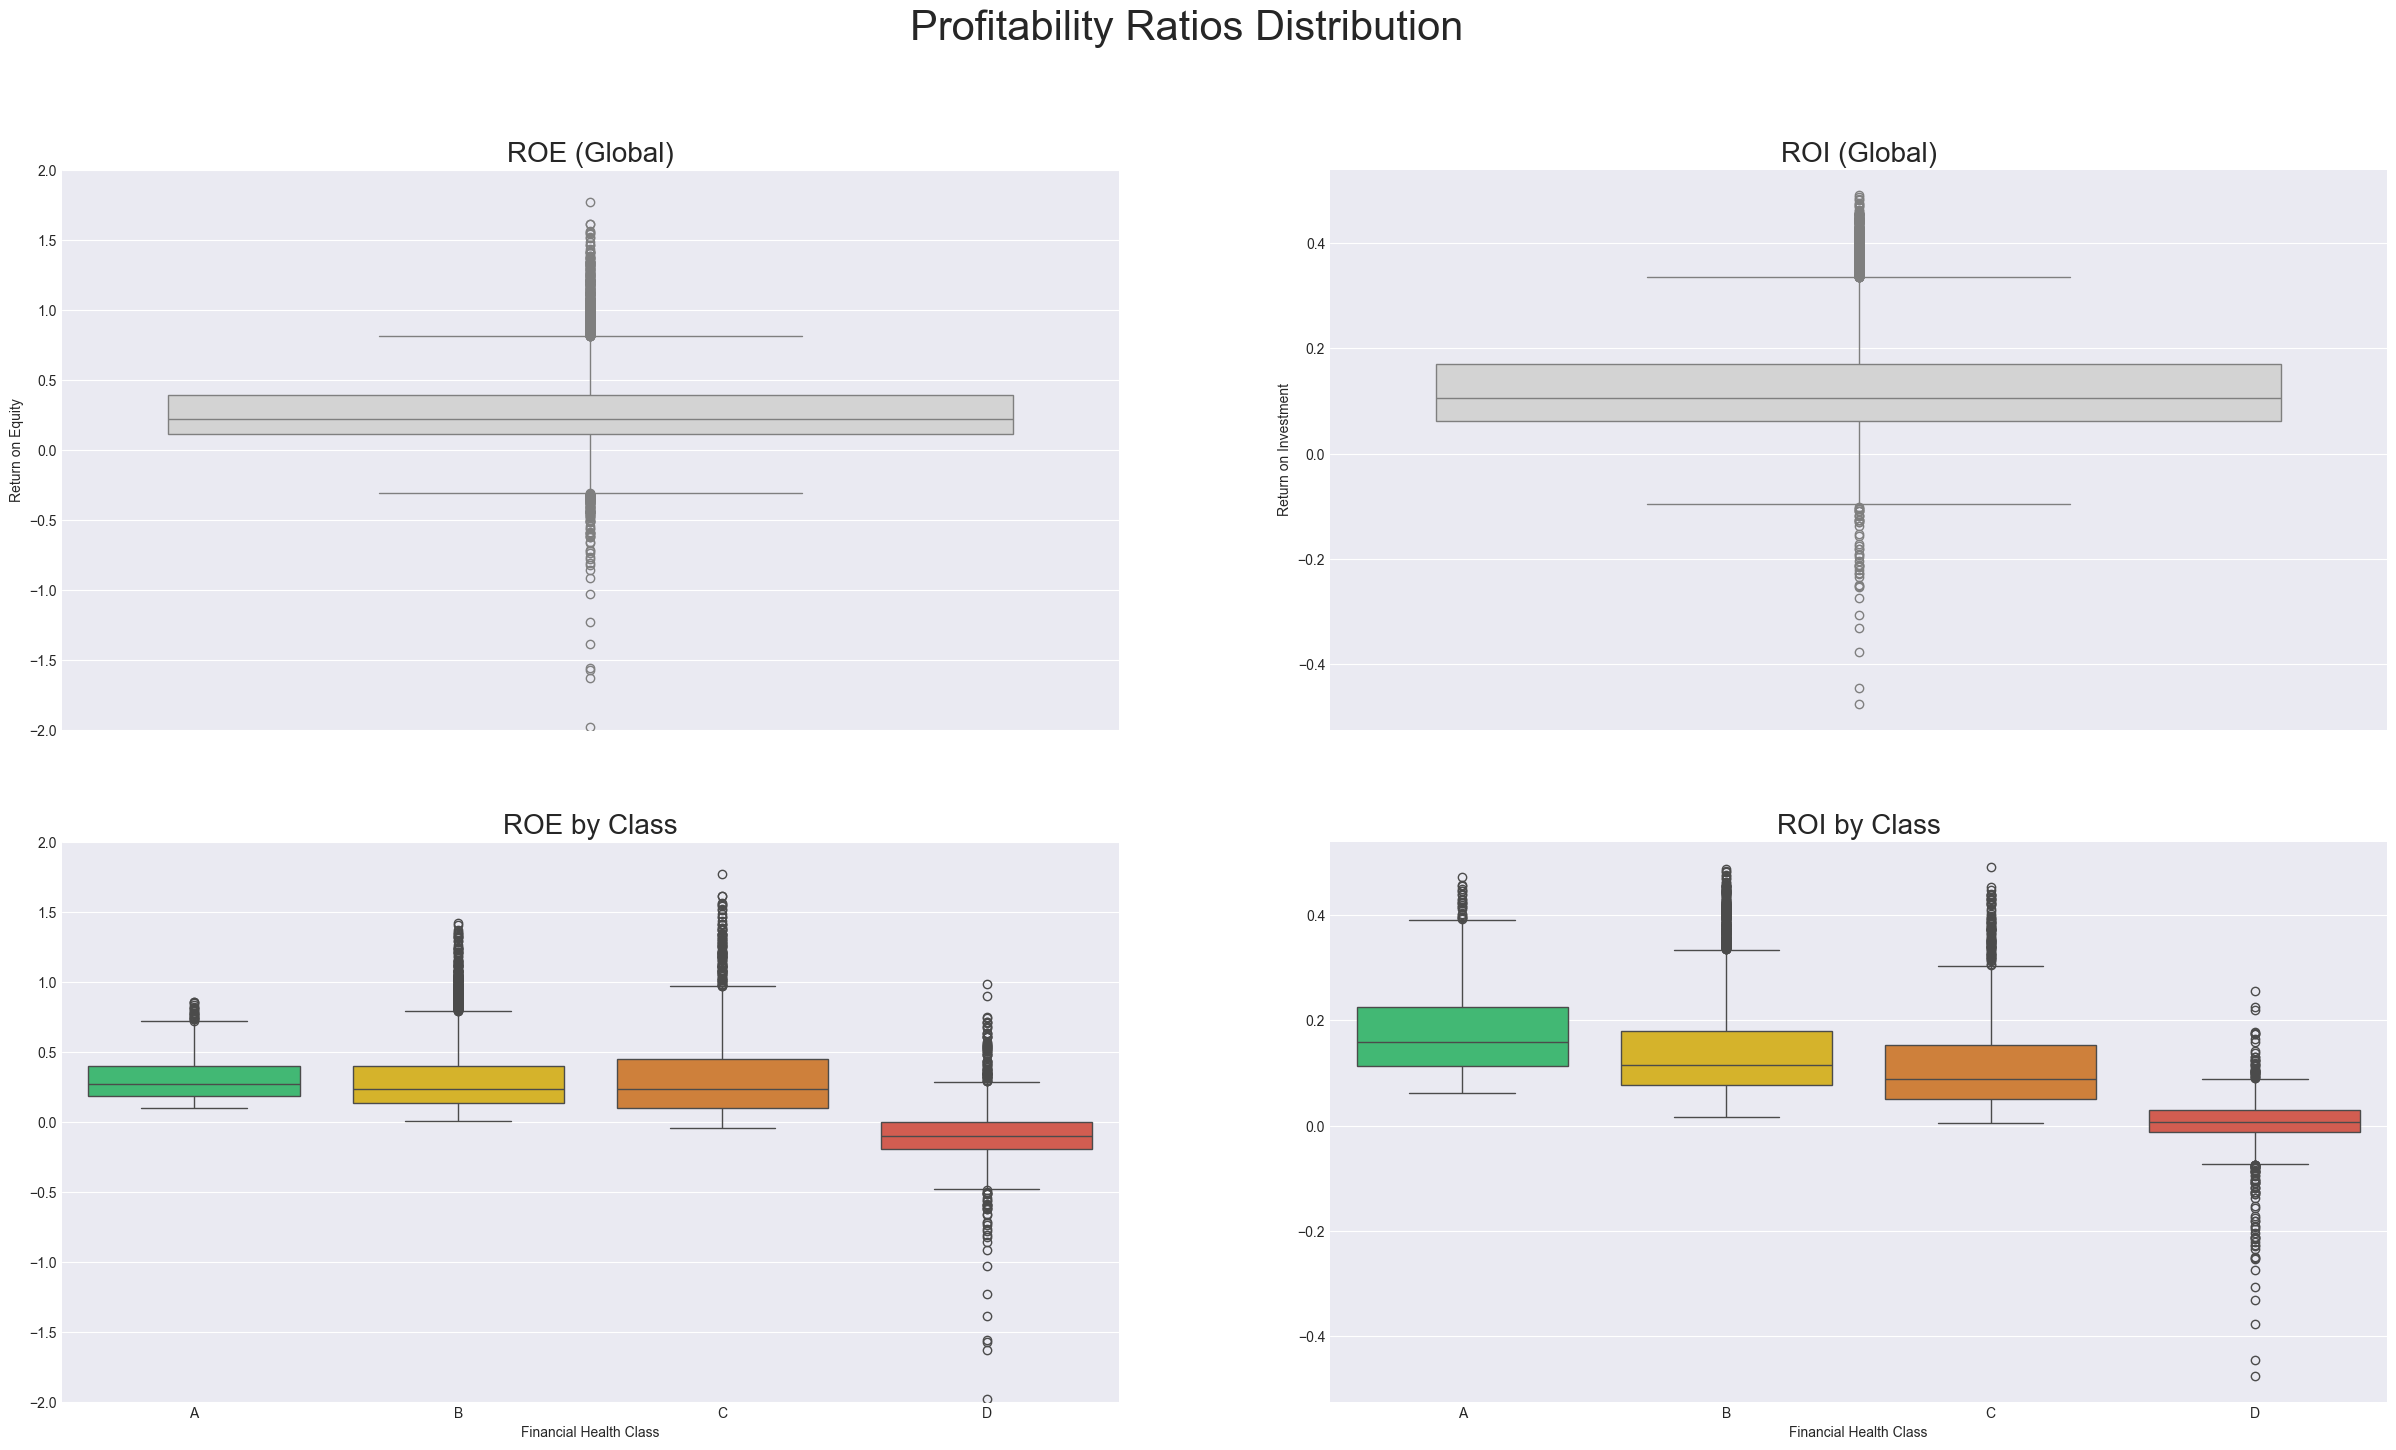

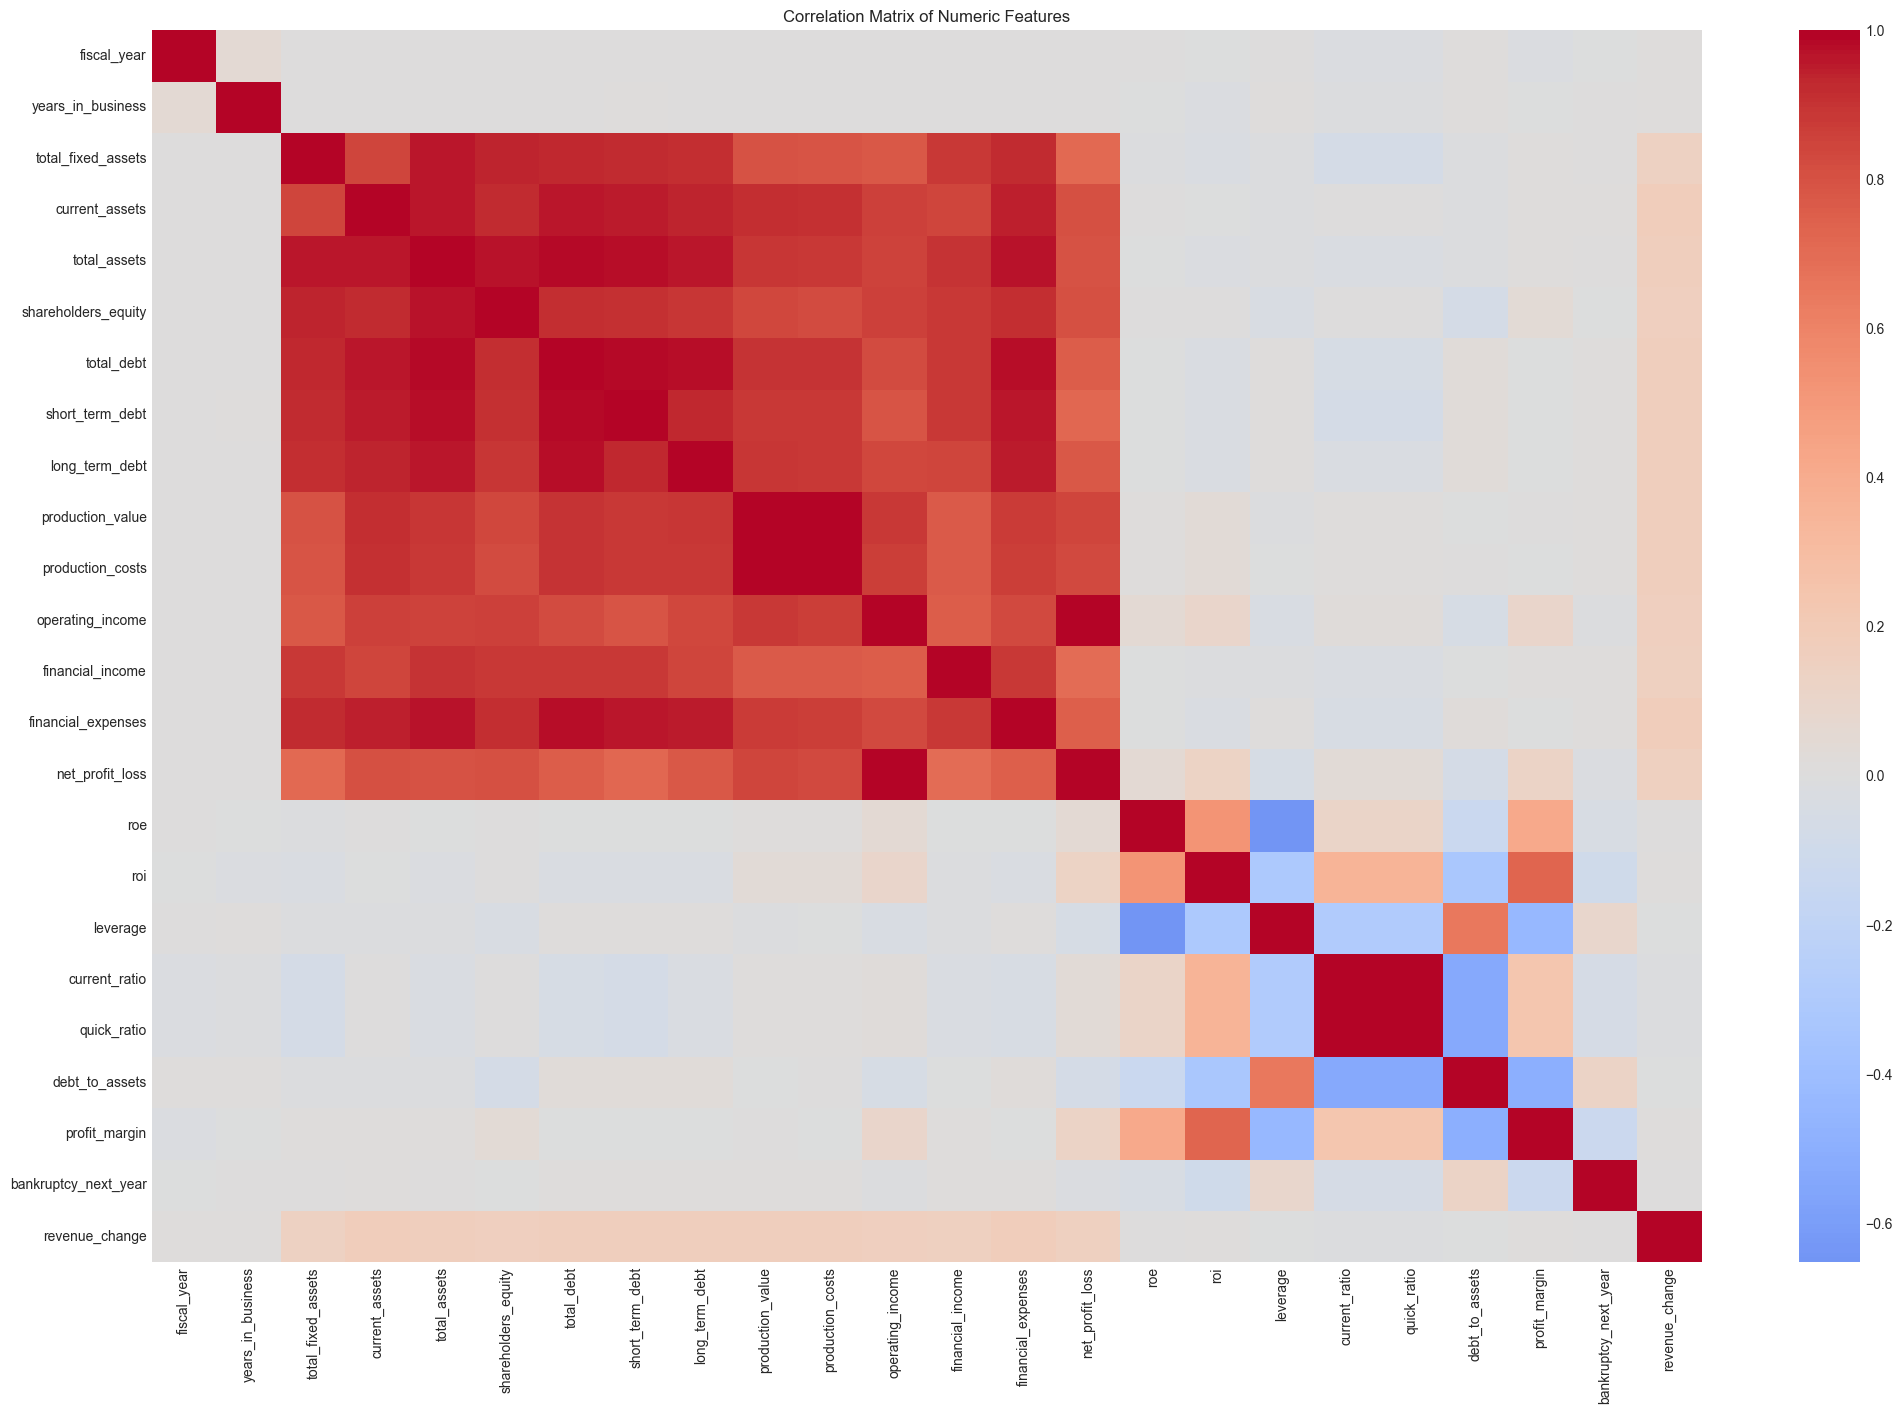

In [ ]:
# TODO: Create visualizations
# - Distribution plots for key financial ratios

#here we will create boxplots for key financial ratios to visualize their distributions globally and by financial health class.
#liquidity ratios
fig, axes = plt.subplots(2, 2, figsize=(30, 16))
fig.suptitle('Liquidity Ratios Distribution', fontsize=30)

# Global distribution: Current Ratio
sns.boxplot(y='current_ratio', data=train_df, ax=axes[0,0], color='lightgray')
axes[0,0].set_title('Current Ratio (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Current Ratio')
# Global distribution: Quick Ratio
sns.boxplot(y='quick_ratio', data=train_df, ax=axes[0,1], color='lightgray')
axes[0,1].set_title('Quick Ratio (Global)', fontsize=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Quick Ratio')
# By class: Current Ratio
sns.boxplot(
    x='financial_health_class', y='current_ratio',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_title('Current Ratio by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

# By class: Quick Ratio
sns.boxplot(
    x='financial_health_class', y='quick_ratio',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('Quick Ratio by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')

plt.show()


#leverage ratios
fig, axes = plt.subplots(2,2, figsize=(30, 16))
fig.suptitle('Leverage Ratios Distribution', fontsize=30)

# Global distribution: Leverage
sns.boxplot(y='leverage', data=train_df, ax=axes[0,0], color='lightgray')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Leverage (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Leverage')

#Global distribution: Debt to Assets
sns.boxplot(y='debt_to_assets', data=train_df, ax=axes[0,1], color='lightgray')
axes[0,1].set_title('Debt to Assets (Global)', fontsize=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Debt to Assets')    

# By class: Leverage
sns.boxplot(
    x='financial_health_class', y='leverage',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_yscale('log')
axes[1,0].set_title('Leverage by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

# By class: Debt to Assets
sns.boxplot(
    x='financial_health_class', y='debt_to_assets',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('Debt to Assets by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')

plt.show()


#Profitability ratios
fig, axes = plt.subplots(2, 2, figsize=(30, 16))
fig.suptitle('Profitability Ratios Distribution', fontsize=30)

#Global distribution: ROE
sns.boxplot(y='roe', data=train_df, ax=axes[0,0], color='lightgray')
axes[0,0].set_ylim(-2, 2)
axes[0,0].set_title('ROE (Global)', fontsize=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Return on Equity')

#Global distribution: ROI
sns.boxplot(y='roi', data=train_df, ax=axes[0,1], color='lightgray')
axes[0,1].set_title('ROI (Global)', fontsize=20)           
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Return on Investment')

#By class: ROE
sns.boxplot(
    x='financial_health_class', y='roe',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,0]
)
axes[1,0].set_ylim(-2, 2)
axes[1,0].set_title('ROE by Class', fontsize=20)
axes[1,0].set_xlabel('Financial Health Class')
axes[1,0].set_ylabel('')

#By class: ROI
sns.boxplot(
    x='financial_health_class', y='roi',
    data=train_df, order=["A", "B", "C", "D"],
    palette=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
    ax=axes[1,1]
)
axes[1,1].set_title('ROI by Class', fontsize=20)
axes[1,1].set_xlabel('Financial Health Class')
axes[1,1].set_ylabel('')

plt.show()


#Correlation matrix
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(25, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')

plt.show()


**Key Insights from EDA:**

TODO: Document your key findings
- 
- 
- 

## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [8]:
# Create a copy for preprocessing
df_processed = train_df.copy()

# TODO: Handle missing values
# - Decide on imputation strategy (median, mean, by group, etc.)
# - Document your rationale

# TODO: Handle outliers
# - Identify outliers (IQR, winsorization, etc.)
# - Decide on treatment strategy

# TODO: Encode categorical variables
# - One-hot encoding, label encoding, etc.

print("Preprocessing complete!")

Preprocessing complete!


In [9]:
# Train/Validation split
# IMPORTANT: Use temporal split, not random!

# For Challenges 1 & 2:
# train_years = [2018, 2019, 2020]
# val_year = 2021

# For Challenge 3 (time series):
# train_years = [2018, 2019]
# val_year = 2020
# test_year = 2021

# TODO: Implement temporal split
# df_train = df_processed[df_processed['fiscal_year'].isin(train_years)]
# df_val = df_processed[df_processed['fiscal_year'] == val_year]

print("Train/validation split complete!")

Train/validation split complete!


In [10]:
# Feature scaling
# IMPORTANT: Fit scaler on training data only!

from sklearn.preprocessing import StandardScaler, RobustScaler

# TODO: Choose and apply scaler
# scaler = StandardScaler()  # or RobustScaler() for outlier resistance
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

print("Feature scaling complete!")

Feature scaling complete!


## 4. Feature Engineering

Create new features based on domain knowledge.

In [11]:
# TODO: Engineer features
# Ideas:
# - Financial ratios (if not already present)
# - Year-over-year changes (growth rates)
# - Interaction features
# - Altman Z-Score or similar bankruptcy models
# - Sector-relative features (company vs sector average)
# - Temporal features (trends, volatility)

# Example: Year-over-year change
# df_processed = df_processed.sort_values(['company_id', 'fiscal_year'])
# df_processed['roe_yoy_change'] = df_processed.groupby('company_id')['roe'].diff()

print("Feature engineering complete!")
print(f"Total features: {df_processed.shape[1]}")

Feature engineering complete!
Total features: 30


**Engineered Features:**

TODO: List and explain your engineered features
1. 
2. 
3. 

## 5. Model Development

Train multiple models and compare performance.

In [12]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [13]:
# TODO: Prepare X and y
# feature_cols = [...]  # List your feature columns
# target_col = 'bankruptcy_next_year'  # or 'financial_health_class' or 'revenue_change'

# X_train = df_train[feature_cols]
# y_train = df_train[target_col]
# X_val = df_val[feature_cols]
# y_val = df_val[target_col]

print("Data prepared for modeling!")

Data prepared for modeling!


### Baseline Model

In [14]:
# TODO: Train baseline model
# For classification: Logistic Regression
# For regression: Linear Regression

# Example for Challenge 1 (Bankruptcy):
# baseline_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# baseline_model.fit(X_train_scaled, y_train)
# y_pred_baseline = baseline_model.predict(X_val_scaled)

# print("Baseline Model Performance:")
# print(classification_report(y_val, y_pred_baseline))
# print(f"F1-Score: {f1_score(y_val, y_pred_baseline):.4f}")

### Advanced Models

In [15]:
# TODO: Train multiple models
# - Random Forest
# - XGBoost
# - Gradient Boosting
# - etc.

# For classification with imbalance, consider:
# - SMOTE oversampling
# - Class weights
# - Threshold tuning

# Example for Random Forest with SMOTE:
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,
#     random_state=RANDOM_STATE
# )
# rf_model.fit(X_train_resampled, y_train_resampled)

print("Advanced models trained!")

Advanced models trained!


In [16]:
# TODO: Hyperparameter tuning
# Use GridSearchCV or RandomizedSearchCV

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Example:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=RANDOM_STATE),
#     param_grid,
#     cv=StratifiedKFold(n_splits=5),
#     scoring='f1',
#     n_jobs=-1
# )
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_

print("Hyperparameter tuning complete!")

Hyperparameter tuning complete!


## 6. Model Evaluation

Compare models and select the best one.

In [17]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [18]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [19]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [20]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [21]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀